In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import string

In [2]:
dataset = pd.read_csv('eng_french.csv')
dataset.columns = ['en', 'fe']
devices = tf.config.experimental.list_physical_devices('GPU')
for device in devices:
  tf.config.experimental.set_memory_growth(device, enable=True)

print(dataset.head())

     en          fe
0   Hi.      Salut!
1  Run!     Cours !
2  Run!    Courez !
3  Who?       Qui ?
4  Wow!  Ça alors !


In [3]:
dataset['en'] = dataset['en'].str.lower()
dataset['fe'] = dataset['fe'].str.lower()

en_data = dataset['en'].values
fr_data = dataset['fe'].values

In [4]:
en_data[10]

'stop!'

In [5]:
for i in range(len(fr_data)):
  en_data[i] = 'sos ' + str(en_data[i]) + ' eos'
  fr_data[i] = 'sos ' + str(fr_data[i]) + ' eos'


In [6]:
num_words = 10000
tokenizer_en = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, filters=string.punctuation)   # filters parameter: it removes the characters from the given text, as specified by filter param.
tokenizer_en.fit_on_texts(en_data)
english_sentences = tokenizer_en.texts_to_sequences(en_data)

In [7]:
english_sentences[:5]

[[1, 2768, 2], [1, 417, 2], [1, 417, 2], [1, 77, 2], [1, 3506, 2]]

In [8]:
word_index = tokenizer_en.word_index
print(f"Num words in English(vocab size): {len(word_index)}")

Num words in English(vocab size): 14149


In [9]:
num_words = 10000
tokenizer_fr = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, filters=string.punctuation)   # filters parameter: it removes the characters from the given text, as specified by filter param.
tokenizer_fr.fit_on_texts(fr_data)
french_sentences = tokenizer_fr.texts_to_sequences(fr_data)

In [10]:
word_index = tokenizer_fr.word_index
print(f"Num words in French(vocab size): {len(word_index)}")

Num words in French(vocab size): 27762


In [11]:
# Padding and truncation
max_len = 10
english_sentences = tf.keras.preprocessing.sequence.pad_sequences(english_sentences, maxlen=max_len, padding='post', truncating='post')
french_sentences = tf.keras.preprocessing.sequence.pad_sequences(french_sentences, maxlen=max_len, padding='post', truncating='post')


In [12]:
english_sentences[0]

array([   1, 2768,    2,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [13]:
def positional_encoder(position, embedding_dimension):
    angle_rates = 1 / np.power(10000, (2 * (np.arange(embedding_dimension)[np.newaxis, :] // 2)) / np.float32(embedding_dimension))
    angle_rads = np.arange(position)[:, np.newaxis] * angle_rates

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.sin(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)


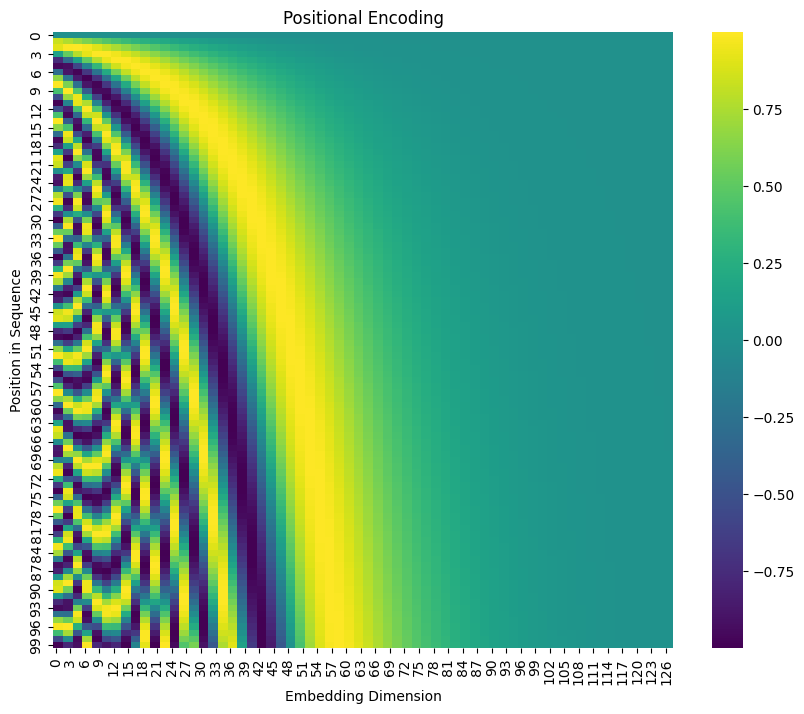

In [14]:
# Test positional encoding
pos_encoding = positional_encoder(100, 128)

# Plot them
plt.figure(figsize=(10, 8))
sns.heatmap(pos_encoding[0], cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.title('Positional Encoding')
plt.show()

In [15]:
def create_padding_mask(sequence):    # Applied to set the attention mask for padding to be 0
# So that they dont contribute to the attention computation
  sequence = tf.cast(tf.math.equal(sequence, 0), tf.float32)
  return sequence[:, tf.newaxis, tf.newaxis, :]

In [16]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)  # Creating look ahead mask so that we dont see the future tokens
  return mask

In [17]:
def create_mask(inputs, targets):
  enc_padding_mask = create_padding_mask(inputs)
  dec_padding_mask = create_padding_mask(inputs)
  look_ahead_mask = create_look_ahead_mask(tf.shape(targets)[1])
  dec_target_padding_mask = create_padding_mask(targets)
  combine_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return enc_padding_mask, combine_mask, dec_padding_mask

In [18]:
def scaled_dot_product(query, key, value, mask):
  matmul_qk = tf.matmul(query, key, transpose_b=True)
  dk = tf.cast(tf.shape(key)[-1], dtype=tf.float32)
  scaled_dk = tf.math.sqrt(dk)
  scaled_attnetion_logits = matmul_qk / scaled_dk

  if mask is not None:
    scaled_attnetion_logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(scaled_attnetion_logits, axis=-1)
  output = tf.matmul(attention_weights, value)
  return output, attention_weights

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, key_dim, num_heads, dropout_rate=0.01):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.key_dim = key_dim

    # Ensure dimension of the embedding can be evenly splot across attention heads
    assert key_dim % num_heads == 0
    self.depth = self.key_dim // self.num_heads

    self.wq = tf.keras.layers.Dense(key_dim)
    self.wk = tf.keras.layers.Dense(key_dim)
    self.wv = tf.keras.layers.Dense(key_dim)

    # dropout rate
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    # dense layer to project the output of the attention heads
    self.dense = tf.keras.layers.Dense(key_dim)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, value, key, query, mask=None):
    batch_size = tf.shape(query)[0]

    # Dense on the q, k, v vectors
    q = self.wq(query)
    k = self.wk(key)
    v = self.wv(value)

    # Split the heads
    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    scaled_attention, attention_weights = scaled_dot_product(q, k, v, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])

    # reshape and add dense layer
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.key_dim))
    output = self.dense(concat_attention)
    return output, attention_weights


In [20]:
def FeedForward(embedding_dimension, fully_connected_dimension):
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(fully_connected_dimension, activation='relu'),
      tf.keras.layers.Dense(embedding_dimension)
  ])
  return model

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1):
    super(EncoderLayer, self).__init__()
    self.mha = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    # Feed forward network
    self.ffn = FeedForward(embedding_dim, fully_connected_dim)


  def call(self, x, training, mask):
    attention_output, _ = self.mha(x, x, x, mask)
    out1 = self.layernorm1(attention_output + x)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout(ffn_output, training=training)

    out2 = self.layernorm2(ffn_output + out1)
    return out2

In [22]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):
    super(Encoder, self).__init__()
    self.num_layers = num_layers
    self.embedding_dim = embedding_dim

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, embedding_dim)

    # Positional encoding
    self.pos_encoding = positional_encoder(maximum_position_encoding, embedding_dim)

    # Encoder layer
    self.enc_layers = [EncoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate) for _ in range(num_layers)]

    # Dropout
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, inputs, training, mask):
    # Get the sequence length.
    seq_len = tf.shape(inputs)[1]

    # Embed the input sequence.
    inputs = self.embedding(inputs)

    # Scale the embedding by sqrt(embedding_dim).
    inputs *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

    # Add positional encodings to the input sequence.
    inputs += self.pos_encoding[:, :seq_len, :]

    inputs = self.dropout(inputs, training=training)

    # Pass the input sequence through the encoder layers.
    for i in range(self.num_layers):
      inputs = self.enc_layers[i](inputs, training=training, mask=mask)

    # Return the encoded sequence.
    return inputs


In [23]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    # Instantiate two instances of MultiHeadAttention
    self.mha1 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
    self.mha2 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)

    # Instantiate Fully connected feedforward networks
    self.ffn = FeedForward(embedding_dim, fully_connected_dim)

    # Instantiate three layer normalization layers with epsilon 1e-6.
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Instantiate a dropout layer for regularization.
    self.dropout3 = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    # Apply the first multi head attention layer to the query vector x.
    # We pass x as the key, query and the value vector. This is self attention
    # layer.
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    # Add the original input to the output of the attention layer.
    out1 = self.layernorm1(attn1 + x)

    # Apply, the second multi-head attention öayer to the output from the first
    # layer and the encoder output
    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)

    # Add the output from the first layer to the output of the second layer and apply layer normalization
    out2 = self.layernorm2(attn2 + out1)

    # Apply the feedforward network to the ouput of second layer and apply dropout regularization.
    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    # Add the output from the second layer to the output of the feedforward network and apply layer normalization
    out3 = self.layernorm3(ffn_output + out2)
    return out3, attn_weights_block1, attn_weights_block2

In [24]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_soze, maximum_position_encoding, dropout_rate):
    super(Decoder, self).__init__()
    self.num_layers = num_layers
    self.embedding_dim = embedding_dim

    # create layers
    self.embedding = tf.keras.layers.Embedding(target_vocab_soze, embedding_dim)
    self.pos_encoding = positional_encoder(maximum_position_encoding, embedding_dim)
    self.dec_layers = [DecoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    seq_len = tf.shape(x)[1]
    attention_weights = {}

    # add embedding and positional encoding
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)

    # apply each layer of decoder
    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output=enc_output,
                                             training=training,
                                             look_ahead_mask=look_ahead_mask,
                                             padding_mask=padding_mask)

      # record attention weights
      attention_weights[f"decoder_layer{i+1}_block1"] = block1
      attention_weights[f"decoder_layer{i+1}_block2"] = block2

    return x, attention_weights



In [25]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, target_vocab_soze, maximum_position_encoding_input, maximum_position_encoding_target, dropout_rate):
    super(Transformer, self).__init__()
    self.encoder = Encoder(num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, maximum_position_encoding_input, dropout_rate)
    self.decoder = Decoder(num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, maximum_position_encoding_target, dropout_rate)

    # Add final softmax layer
    self.final_layer = tf.keras.layers.Dense(target_vocab_soze, activation='softmax')

  def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
    enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)
    dec_output, attention_weights = self.decoder(tar, enc_output=enc_output,
                                                 training=training,
                                                 look_ahead_mask=look_ahead_mask,
                                                 padding_mask=dec_padding_mask)

    # Pass the output of the Decoder through the final dense layer
    final_output = self.final_layer(dec_output)

    return final_output, attention_weights

In [26]:
embedding_dim = 256
fully_connected_dim = 512 # dimensionality of hidden layer of feed forward NN
num_layers = 4 # Num of transformer blocks in the encoder and decoder stack
num_heads = 8  # Num of heads in multi head attention mechanism
dropout_rate = 0.1

input_vocab_size = len(tokenizer_fr.word_index) + 2   # one for start and end token
target_vocab_soze = len(tokenizer_en.word_index) + 2

# maximum positional encoding for input and the target
max_positional_encoding_input = input_vocab_size
max_positional_encoding_target = target_vocab_soze

# Setting hyperparams.
EPOCHS = 10
batch_size = 256


In [27]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, embedding_dim, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.embedding_dim = tf.cast(embedding_dim, dtype=tf.float32)
    self.warmup_steps = tf.cast(warmup_steps, dtype=tf.float32)

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1, arg2)

# Create an instance of custom learning rate schedule
learning_rate = CustomSchedule(embedding_dim)

In [28]:
transformer = Transformer(num_layers, embedding_dim, num_heads,
                          fully_connected_dim, input_vocab_size, target_vocab_soze, max_positional_encoding_input,
                          max_positional_encoding_target, dropout_rate)

# Define the optimizers
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Define the loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [29]:
def loss_function(true_value, prediction):
  mask = tf.math.logical_not(tf.math.equal(true_value, 0))
  loss_ = loss_object(true_value, prediction)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [30]:
def accuracy_function(true_value, prediction):
  accuracies = tf.equal(true_value, tf.argmax(prediction, axis=2))
  mask = tf.math.logical_not(tf.math.equal(true_value, 0))

  # Apply the mask to exclude the padding token from the accuracies
  accuracies = tf.math.logical_and(mask, accuracies)
  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)

  return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

In [31]:
# Define training metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalCrossentropy(name='train_accuracy')

In [32]:
@tf.function()
def train_step(encoder_input, target):

  # Slice the target tensor to get the input for the decoder
  decoder_input = target[:, :-1]

  # Slice the target tensor to get the expected output of the decoder
  expected_output = target[:, 1:]

  # Create mask for encoder input, decoder input and the padding
  enc_padding_mask, combined_mask, dec_padding_mask = create_mask(encoder_input,
                                                                  decoder_input)
  with tf.GradientTape() as tape:
    prediction, _ = transformer(encoder_input, decoder_input, training=True,
                                enc_padding_mask=enc_padding_mask,
                                look_ahead_mask=combined_mask,
                                dec_padding_mask=dec_padding_mask)
    loss = loss_function(expected_output, prediction)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  # Update the training loss and accuracy metrices
  train_loss.update_state(loss)
  train_accuracy.update_state(expected_output, prediction)

In [33]:
for epoch in range(0, EPOCHS+1):
  train_loss.reset_state()
  train_accuracy.reset_state()
  current_batch_index = 0

  for i in range(int(len(english_sentences) / batch_size)):
    input_batch = tf.convert_to_tensor(np.array(english_sentences[current_batch_index: current_batch_index + batch_size]), dtype=tf.int64)
    target_batch = tf.convert_to_tensor(np.array(french_sentences[current_batch_index: current_batch_index + batch_size]), dtype=tf.int64)

    current_batch_index = current_batch_index + batch_size
    train_step(input_batch, target_batch)

  # Print the epochs loss
  print(f'Epoch {epoch} Loss: {train_loss.result():.4f} Accuracy: {train_accuracy.result():.4f}')

Epoch 0 Loss: 6.3972 Accuracy: 6.3972
Epoch 1 Loss: 3.2383 Accuracy: 3.2383
Epoch 2 Loss: 2.0948 Accuracy: 2.0948
Epoch 3 Loss: 1.4693 Accuracy: 1.4693
Epoch 4 Loss: 1.2105 Accuracy: 1.2105
Epoch 5 Loss: 1.0883 Accuracy: 1.0883
Epoch 6 Loss: 0.9772 Accuracy: 0.9772
Epoch 7 Loss: 0.8546 Accuracy: 0.8546
Epoch 8 Loss: 0.7641 Accuracy: 0.7641
Epoch 9 Loss: 0.6941 Accuracy: 0.6941
Epoch 10 Loss: 0.6426 Accuracy: 0.6426


In [34]:
transformer.save_weights('transformer_en_fr.weights.h5')

In [50]:
text = 'love you'
text = "sos " + text.lower() + " eos"

inp_seq = tf.keras.utils.pad_sequences(tokenizer_en.texts_to_sequences([text]),
                                       maxlen=10, padding='post')
out_seq = tf.convert_to_tensor([[tokenizer_fr.word_index['sos']]])

In [51]:
# create mask for input seq
enc_padding_mask, combined_mask, dec_padding_mask = create_mask(inp_seq, out_seq)

In [52]:
output_tokens = []
for i in range(100):
  output, attn_weights = transformer(inp_seq, out_seq, training=False,
                                enc_padding_mask=enc_padding_mask,
                                look_ahead_mask=combined_mask,
                                dec_padding_mask=dec_padding_mask)
  last_token = output[:, -1:, :]
  # Getting the token with highest probability
  predicted_token = tf.cast(tf.argmax(last_token, axis=-1), tf.int32)

  # check if the end token is the final one
  if predicted_token == tokenizer_fr.word_index['eos']:
    break
  # Append the predicted token to the ouptut token list
  output_tokens.append(predicted_token[0][0].numpy())

  # Concatenate the predicted token to the output seq
  out_seq = tf.concat([out_seq, predicted_token], axis=-1)

  # Update the mask for the output sequence
  decoder_padding_mask, look_ahead_mask = create_padding_mask(out_seq), create_look_ahead_mask(tf.shape(out_seq)[1])
  combined_mask = tf.maximum(decoder_padding_mask, look_ahead_mask)

In [53]:
output_tokens = tf.convert_to_tensor([output_tokens])

In [54]:
tokenizer_fr.sequences_to_texts(output_tokens.numpy())

['vous aimez vous l amour']